<a href="https://colab.research.google.com/github/isj0/DeepLearning/blob/main/Test_Run_NSL_KDD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import ibraries and load dataset

In [38]:
# Import required libraries

from datasets import load_dataset
import pandas as pd
import numpy as np
from datasets import load_dataset
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
# Load the NSL-KDD dataset from HuggingFace
ds = load_dataset("Mireu-Lab/NSL-KDD")

In [40]:
# Hugging Face datasets need to be converted to Pandas DataFrame for easy handling

# Convert train and test splits to DataFrames
train_df = pd.DataFrame(ds['train'])
test_df = pd.DataFrame(ds['test'])

### Explore dataset

In [41]:
# Display first 5 rows of the training data
print("First 5 rows of the training dataset:")
print(train_df.head())

First 5 rows of the training dataset:
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                    0.03   
1                    0.00                    0.60   
2              

In [42]:
# Display shape (rows, columns)
print("\nTraining dataset shape:", train_df.shape)
print("Testing dataset shape:", test_df.shape)


Training dataset shape: (151165, 42)
Testing dataset shape: (34394, 42)


In [43]:
# Display column names
print("\nColumns in the dataset:")
print(train_df.columns)



Columns in the dataset:
Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class'],
      dtype='object')


In [44]:

# Check data types of each column
print("\nData types of each column:")
print(train_df.dtypes)


Data types of each column:
duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float

In [45]:
# Check target class distribution
print("\nDistribution of attack types in training dataset:")
print(train_df['class'].value_counts())


Distribution of attack types in training dataset:
class
normal     80792
anomaly    70373
Name: count, dtype: int64


In [46]:
print("\nClass distribution (%):")
print(train_df['class'].value_counts(normalize=True)*100)



Class distribution (%):
class
normal     53.446234
anomaly    46.553766
Name: proportion, dtype: float64


### Data Cleaning

In [47]:
# Check for duplicate rows in training and test datasets
print("Number of duplicate rows in training set:", train_df.duplicated().sum())
print("Number of duplicate rows in test set:", test_df.duplicated().sum())


Number of duplicate rows in training set: 25201
Number of duplicate rows in test set: 11853


In [48]:
# Remove duplicate rows
train_df = train_df.drop_duplicates()
test_df = test_df.drop_duplicates()

# Check for duplicate rows after removing duplicates
print("Number of duplicate rows in training set:", train_df.duplicated().sum())
print("Number of duplicate rows in test set:", test_df.duplicated().sum())


Number of duplicate rows in training set: 0
Number of duplicate rows in test set: 0


In [49]:
# Check for missing values
print("Missing values in training set:\n", train_df.isnull().sum())
print("Missing values in test set:\n", test_df.isnull().sum())


Missing values in training set:
 duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_r

In [50]:
# Convert target column to numeric: normal=0, anomaly=1
train_df['label'] = train_df['class'].apply(lambda x: 0 if x=='normal' else 1)
test_df['label'] = test_df['class'].apply(lambda x: 0 if x=='normal' else 1)

# Drop original 'class' column
train_df.drop('class', axis=1, inplace=True)
test_df.drop('class', axis=1, inplace=True)


### Data preprocessing

In [51]:
# Step 2.1: One-hot encode categorical features

categorical_features = ['protocol_type', 'service', 'flag']

# Convert categorical features to one-hot encoded columns
train_df_encoded = pd.get_dummies(train_df, columns=categorical_features)
test_df_encoded = pd.get_dummies(test_df, columns=categorical_features)


In [52]:
# Step 2.2: Align train and test after one-hot encoding
train_df_encoded, test_df_encoded = train_df_encoded.align(test_df_encoded, join='left', axis=1, fill_value=0)

# Confirm they have the same number of columns
print("Training features shape:", train_df_encoded.shape)
print("Testing features shape:", test_df_encoded.shape)


Training features shape: (125964, 123)
Testing features shape: (22541, 123)


In [53]:
# Step: Scale numeric features

# 1. Identify numeric columns
numeric_cols = train_df.select_dtypes(include=np.number).columns.tolist()
numeric_cols.remove('label')  # remove target column from features

print("Numeric columns to scale:", numeric_cols)

# 2. Initialize the scaler
scaler = StandardScaler()

# 3. Fit the scaler on training data numeric columns and transform
train_df_encoded[numeric_cols] = scaler.fit_transform(train_df_encoded[numeric_cols])

# 4. Transform the test data using the same scaler
test_df_encoded[numeric_cols] = scaler.transform(test_df_encoded[numeric_cols])

# 5. Check a few rows to see scaled numeric features
print("Numeric features scaled. Sample data:")
print(train_df_encoded[numeric_cols].head())


Numeric columns to scale: ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']
Numeric features scaled. Sample data:
   duration  src_bytes  dst_bytes      land  wrong_fragment    urgent  \
0 -0.110253  -0.007679  -0.004919 -0.014089        -0.08949 -0.007736   
1 -0.110253  -0.007738  -0.004919 -0.014089        -0.08949 -0.007736   
2 -0.110253  -0.007763  

In [54]:
# Step 2.3: Apply PCA to reduce dimensionality
# Keep enough components to retain 95% of variance

# 1. Separate features and target
X_train = train_df_encoded.drop('label', axis=1)
y_train = train_df_encoded['label']

X_test = test_df_encoded.drop('label', axis=1)
y_test = test_df_encoded['label']

# 2. Initialize PCA to retain 95% of variance
pca = PCA(n_components=0.95, random_state=42)

# 3. Fit PCA on training features and transform
X_train_pca = pca.fit_transform(X_train)

# 4. Transform test features using the same PCA
X_test_pca = pca.transform(X_test)

# 5. Check how many components PCA kept
print("Original number of features:", X_train.shape[1])
print("Reduced number of features after PCA:", X_train_pca.shape[1])


Original number of features: 122
Reduced number of features after PCA: 24


### Supervised Model (Baseline)

In [55]:
# ================================================================
# FUNCTION: evaluation_metrics
# ================================================================
# This function computes and prints key classification metrics.
# We will use it for every model we train (supervised, unsupervised, ensemble).
# ---------------------------------------------------------------

# Global storage dictionary (empty for now)
model_results = {}

# ================================================================
# FUNCTION: evaluation_metrics (updated)
# ================================================================
def evaluation_metrics(y_true, y_pred, model_name="Model"):

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Print metrics
    print(f"\n{model_name} Performance:")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")

    # Store metrics in the global dictionary
    model_results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1
    }

    # Return metrics dict (optional, useful for tables later)
    return model_results[model_name]





In [56]:
# ================================================================
# FUNCTION: plot_confusion_matrix
# ================================================================
# This function plots a confusion matrix as a heatmap for any model.
# ---------------------------------------------------------------
def plot_confusion_matrix(y_true, y_pred, model_name="Model"):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plotting
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{model_name} Confusion Matrix")
    plt.ylabel("Actual Label")
    plt.xlabel("Predicted Label")
    plt.show()



Logistic Regression Performance:
Accuracy : 0.7552
Precision: 0.9230
Recall   : 0.6217
F1-score : 0.7430


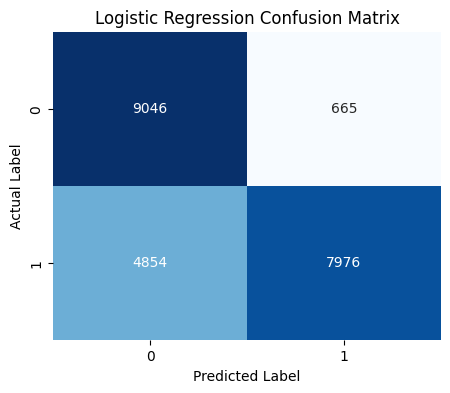

In [57]:
# 1: Supervised Baseline - Logistic Regression

# Initialize the model
logreg = LogisticRegression(random_state=42, max_iter=1000)  # max_iter increased to ensure convergence

# Fit the model on PCA-transformed training data
logreg.fit(X_train_pca, y_train)

# Predict on test data
y_pred_logreg = logreg.predict(X_test_pca)

# Evaluate metrics
evaluation_metrics(y_test, y_pred_logreg, model_name="Logistic Regression")

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_logreg, model_name="Logistic Regression")




Decision Tree Performance:
Accuracy : 0.7679
Precision: 0.9304
Recall   : 0.6401
F1-score : 0.7584


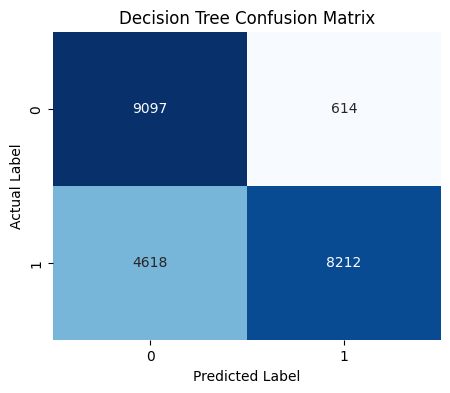

In [58]:
## 2: Supervised Baseline - Decision Tree


# Initialize the Decision Tree
dt = DecisionTreeClassifier(random_state=42)

# Fit the model on PCA-transformed training data
dt.fit(X_train_pca, y_train)

# Predict on test data
y_pred_dt = dt.predict(X_test_pca)

# Evaluate metrics
evaluation_metrics(y_test, y_pred_dt, model_name="Decision Tree")

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_dt, model_name="Decision Tree")



Random Forest Performance:
Accuracy : 0.7321
Precision: 0.9290
Recall   : 0.5731
F1-score : 0.7089


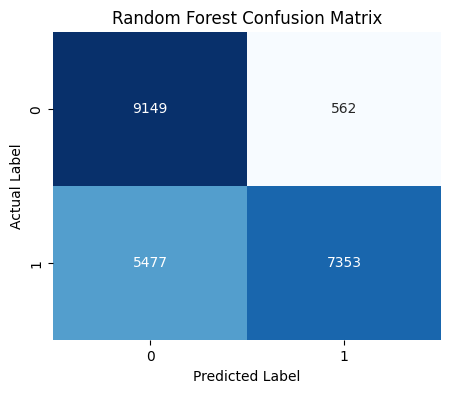

In [59]:
# 3: Supervised Baseline - Random Forest

# Initialize the Random Forest
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Fit the model on PCA-transformed training data
rf.fit(X_train_pca, y_train)

# Predict on test data
y_pred_rf = rf.predict(X_test_pca)

# Evaluate metrics
evaluation_metrics(y_test, y_pred_rf, model_name="Random Forest")

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_rf, model_name="Random Forest")



SVM Performance:
Accuracy : 0.7660
Precision: 0.9232
Recall   : 0.6422
F1-score : 0.7575


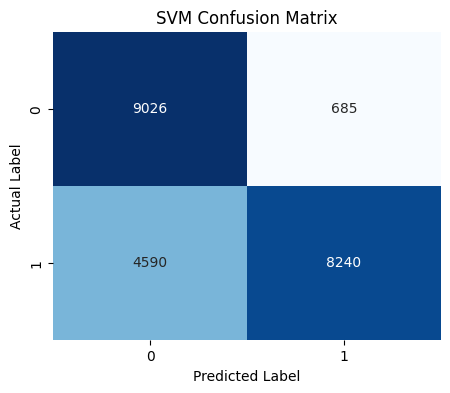

In [60]:
# 4: Supervised Baseline - SVM


# Initialize the SVM (RBF kernel)
svm_model = SVC(kernel='rbf', random_state=42)

# Fit the model on PCA-transformed training data
svm_model.fit(X_train_pca, y_train)

# Predict on test data
y_pred_svm = svm_model.predict(X_test_pca)

# Evaluate metrics
evaluation_metrics(y_test, y_pred_svm, model_name="SVM")

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_svm, model_name="SVM")



MLP Performance:
Accuracy : 0.7591
Precision: 0.9706
Recall   : 0.5948
F1-score : 0.7376


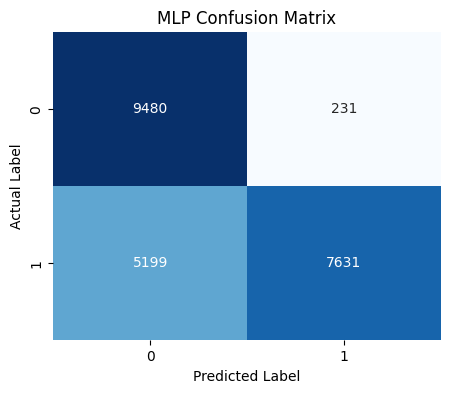

In [23]:
# 5: Supervised Baseline - MLP


# Initialize MLP
mlp_model = MLPClassifier(hidden_layer_sizes=(50,), max_iter=200, random_state=42)

# Fit the model
mlp_model.fit(X_train_pca, y_train)

# Predict on test data
y_pred_mlp = mlp_model.predict(X_test_pca)

# Evaluate metrics
evaluation_metrics(y_test, y_pred_mlp, model_name="MLP")

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_mlp, model_name="MLP")


Fitting 3 folds for each of 10 candidates, totalling 30 fits

Random Forest tuning completed in 2780.29 seconds

Best Random Forest Hyperparameters (Fast):
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}

Random Forest (Tuned Fast) Performance:
Accuracy : 0.7316
Precision: 0.9300
Recall   : 0.5714
F1-score : 0.7079


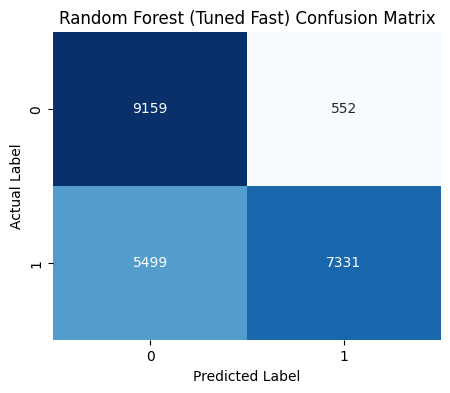

In [24]:
# # ================================================================
# # FAST Random Forest Hyperparameter Tuning using RandomizedSearchCV
# # ================================================================

# import time

# # Reduced hyperparameter grid for practical tuning
# rf_param_grid_fast = {
#     "n_estimators": [50, 100, 200],       # fewer trees
#     "max_depth": [None, 10, 20],          # shallower depths
#     "min_samples_split": [2, 5, 10],      # fewer options
#     "min_samples_leaf": [1, 2, 4],        # fewer options
#     "max_features": ["sqrt", 0.5],        # only safe options
#     "bootstrap": [True]                    # stick to bootstrap
# }

# # Initialize Random Forest
# rf = RandomForestClassifier(random_state=42)

# # RandomizedSearchCV: faster settings
# rf_random_search_fast = RandomizedSearchCV(
#     estimator=rf,
#     param_distributions=rf_param_grid_fast,
#     n_iter=10,          # try only 10 random combinations
#     cv=3,               # 3-fold CV
#     scoring='f1',       # focus on F1 due to class imbalance
#     verbose=2,
#     random_state=42,
#     n_jobs=-1           # use all cores
# )

# # Fit on PCA features
# start_time = time.time()
# rf_random_search_fast.fit(X_train_pca, y_train)
# end_time = time.time()

# print(f"\nRandom Forest tuning completed in {end_time - start_time:.2f} seconds")

# # Display best hyperparameters
# best_rf_params = rf_random_search_fast.best_params_
# print("\nBest Random Forest Hyperparameters (Fast):")
# print(best_rf_params)

# # Evaluate best model
# best_rf_model = rf_random_search_fast.best_estimator_
# y_pred_rf_best = best_rf_model.predict(X_test_pca)

# # Metrics and confusion matrix
# evaluation_metrics(y_test, y_pred_rf_best, model_name="Random Forest (Tuned Fast)")
# plot_confusion_matrix(y_test, y_pred_rf_best, model_name="Random Forest (Tuned Fast)")



Training Random Forest on ORIGINAL FEATURES (no PCA)...

Random Forest (No PCA) Performance:
Accuracy : 0.7694
Precision: 0.9681
Recall   : 0.6150
F1-score : 0.7522


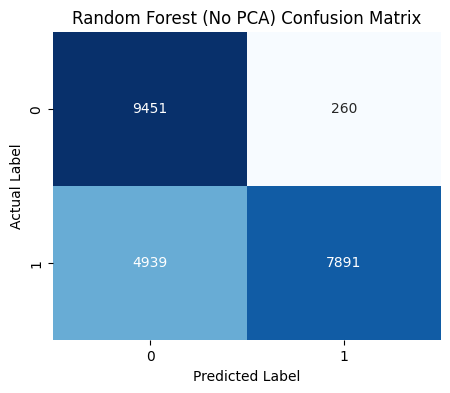

In [25]:
# # ==========================================
# # Random Forest on Original Features (No PCA)
# # ==========================================

# from sklearn.ensemble import RandomForestClassifier

# print("\nTraining Random Forest on ORIGINAL FEATURES (no PCA)...")

# rf_no_pca = RandomForestClassifier(
#     n_estimators=300,
#     max_depth=None,
#     max_features='sqrt',
#     class_weight='balanced',   # IMPORTANT: fixes low recall
#     random_state=42,
#     n_jobs=-1
# )

# rf_no_pca.fit(X_train, y_train)

# # Predictions
# y_pred_rf_no_pca = rf_no_pca.predict(X_test)

# # Evaluate
# evaluation_metrics(y_test, y_pred_rf_no_pca, model_name="Random Forest (No PCA)")
# plot_confusion_matrix(y_test, y_pred_rf_no_pca, model_name="Random Forest (No PCA)")


In [26]:
# # ==========================================
# # Random Forest With Manual Class Weights
# # ==========================================

# weights_to_test = [
#     {"class_weight": "balanced"},
#     {"class_weight": {0:1, 1:3}},
#     {"class_weight": {0:1, 1:5}}
# ]

# for w in weights_to_test:
#     print("\nTesting RF with class_weight =", w["class_weight"])

#     rf_w = RandomForestClassifier(
#         n_estimators=300,
#         max_depth=None,
#         max_features='sqrt',
#         class_weight=w["class_weight"],
#         random_state=42,
#         n_jobs=-1
#     )

#     rf_w.fit(X_train, y_train)
#     y_pred_w = rf_w.predict(X_test)

#     evaluation_metrics(
#         y_test, y_pred_w,
#         model_name=f"RF class_weight={w['class_weight']}"
#     )



Testing RF with class_weight = balanced

RF class_weight=balanced Performance:
Accuracy : 0.7694
Precision: 0.9681
Recall   : 0.6150
F1-score : 0.7522

Testing RF with class_weight = {0: 1, 1: 3}

RF class_weight={0: 1, 1: 3} Performance:
Accuracy : 0.7561
Precision: 0.9665
Recall   : 0.5920
F1-score : 0.7342

Testing RF with class_weight = {0: 1, 1: 5}

RF class_weight={0: 1, 1: 5} Performance:
Accuracy : 0.7572
Precision: 0.9677
Recall   : 0.5931
F1-score : 0.7355


Fitting 3 folds for each of 10 candidates, totalling 30 fits

SVM tuning completed in 2964.66 seconds

Best SVM Hyperparameters:
{'kernel': 'rbf', 'gamma': 0.1, 'C': 50}

SVM (Tuned) Performance:
Accuracy : 0.7626
Precision: 0.9690
Recall   : 0.6022
F1-score : 0.7428


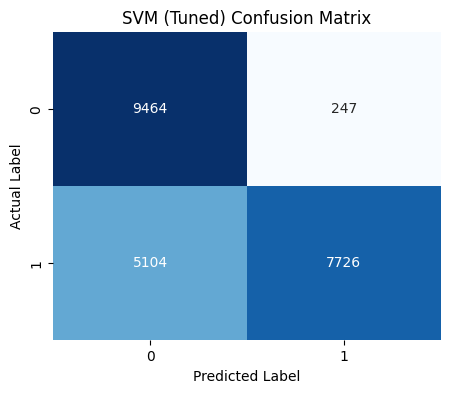

In [61]:
# Here’s a fast SVM hyperparameter tuning setup using RandomizedSearchCV:

from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
import time

# Step 1: Define a reduced hyperparameter grid for SVM
svm_param_grid = {
    'C': [0.1, 1, 10, 50],           # regularization
    'gamma': ['scale', 0.01, 0.1],   # kernel coefficient
    'kernel': ['rbf']                 # RBF kernel
}

# Step 2: Initialize the SVM
svm_model = SVC(random_state=42)

# Step 3: Set up RandomizedSearchCV for faster tuning
svm_random_search = RandomizedSearchCV(
    estimator=svm_model,
    param_distributions=svm_param_grid,
    n_iter=10,        # try only 10 random combinations
    cv=3,             # 3-fold cross-validation
    scoring='f1',     # focus on F1-score due to class imbalance
    verbose=2,
    random_state=42,
    n_jobs=-1         # use all CPU cores
)

# Step 4: Fit on PCA-reduced training data
start_time = time.time()
svm_random_search.fit(X_train_pca, y_train)
end_time = time.time()

print(f"\nSVM tuning completed in {end_time - start_time:.2f} seconds")

# Step 5: Display best hyperparameters
best_svm_params = svm_random_search.best_params_
print("\nBest SVM Hyperparameters:")
print(best_svm_params)

# Step 6: Evaluate the best SVM on test data
best_svm_model = svm_random_search.best_estimator_
y_pred_svm_best = best_svm_model.predict(X_test_pca)

# Metrics and confusion matrix
evaluation_metrics(y_test, y_pred_svm_best, model_name="SVM (Tuned)")
plot_confusion_matrix(y_test, y_pred_svm_best, model_name="SVM (Tuned)")




Training Gradient Boosting Classifier...

Gradient Boosting Performance:
Accuracy : 0.7833
Precision: 0.9685
Recall   : 0.6401
F1-score : 0.7708


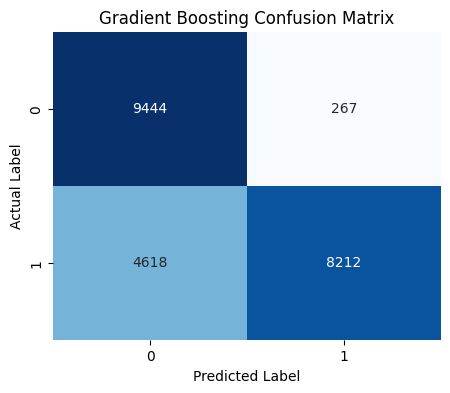

In [62]:
from sklearn.ensemble import GradientBoostingClassifier

print("\nTraining Gradient Boosting Classifier...")

gb = GradientBoostingClassifier(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

evaluation_metrics(y_test, y_pred_gb, model_name="Gradient Boosting")
plot_confusion_matrix(y_test, y_pred_gb, model_name="Gradient Boosting")




Training Isolation Forest (Unsupervised)...

Isolation Forest Performance:
Accuracy : 0.7954
Precision: 0.8068
Recall   : 0.8423
F1-score : 0.8242


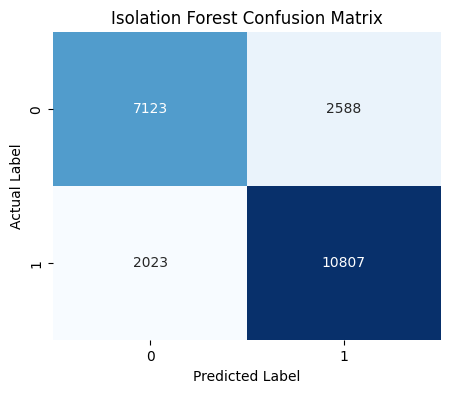

In [63]:

print("\nTraining Isolation Forest (Unsupervised)...")

iso = IsolationForest(
    n_estimators=200,
    contamination=y_train.mean(),  # ratio of anomalies
    max_samples='auto',
    random_state=42,
    n_jobs=-1
)

# Fit using ONLY X_train (no labels)
iso.fit(X_train)

# Isolation Forest outputs:
#   -1 = anomaly
#    1 = normal
y_pred_iso = iso.predict(X_test)

# Convert to 0/1
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)

evaluation_metrics(y_test, y_pred_iso, model_name="Isolation Forest")
plot_confusion_matrix(y_test, y_pred_iso, model_name="Isolation Forest")




Hybrid Ensemble Performance:
Accuracy : 0.8483
Precision: 0.8225
Recall   : 0.9352
F1-score : 0.8753


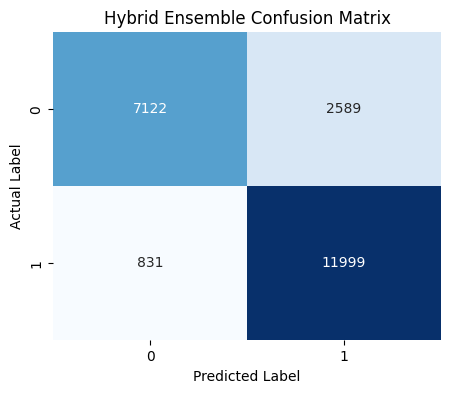

In [65]:
# ---- 1) Supervised prediction ----
gb_pred = y_pred_gb  # reuse previously trained Gradient Boosting predictions

# ---- 2) Isolation Forest prediction ----
iso_pred = y_pred_iso  # reuse previously trained Isolation Forest predictions

# ---- 3) Hybrid ensemble decision rule ----
# Attack if ANY model flags it
ensemble_pred = np.where((gb_pred + iso_pred) >= 1, 1, 0)

# ---- 4) Evaluate hybrid ensemble ----
evaluation_metrics(y_test, ensemble_pred, model_name="Hybrid Ensemble")
plot_confusion_matrix(y_test, ensemble_pred, model_name="Hybrid Ensemble")


In [66]:
# ---------------------------------------------------------------
# STEP: Summarize all model metrics in a table
# ---------------------------------------------------------------


# 1️⃣ Convert the global dictionary `model_results` into a DataFrame
# - Each key in the dictionary is a model name
# - Each value is another dictionary containing Accuracy, Precision, Recall, F1
# - Transpose (.T) so that models become rows and metrics become columns
results_df = pd.DataFrame(model_results).T

# 2️⃣ Display the raw results table
# - This shows all models and their corresponding metrics
print("All Model Metrics (Unsorted):")
display(results_df)  # nicer display in Jupyter/Colab

# 3️⃣ Optional: sort the table by F1-score in descending order
# - Useful to quickly identify top-performing models
results_df_sorted = results_df.sort_values("F1", ascending=False)

# 4️⃣ Display the sorted results
print("\nAll Model Metrics (Sorted by F1-score):")
display(results_df_sorted)

# ---------------------------------------------------------------
# Notes:
# - You can also sort by Accuracy, Precision, or Recall by changing the column name
# - This table will help decide which model to focus on for hyperparameter tuning
# - No additional fitting is done here; it only summarizes previously computed metrics
# ---------------------------------------------------------------


All Model Metrics (Unsorted):


,Accuracy,Precision,Recall,F1
Logistic Regression,0.755157,0.923041,0.621668,0.742956
Decision Tree,0.767890,0.930433,0.640062,0.758404
Random Forest,0.732088,0.928996,0.573110,0.708894
SVM,0.765982,0.923249,0.642245,0.757527
SVM (Tuned),0.762610,0.969020,0.602182,0.742777
Gradient Boosting,0.783284,0.968510,0.640062,0.770754
Isolation Forest,0.795439,0.806794,0.842323,0.824175
Hybrid Ensemble,0.848276,0.822525,0.935230,0.875264



All Model Metrics (Sorted by F1-score):


,Accuracy,Precision,Recall,F1
Hybrid Ensemble,0.848276,0.822525,0.935230,0.875264
Isolation Forest,0.795439,0.806794,0.842323,0.824175
Gradient Boosting,0.783284,0.968510,0.640062,0.770754
Decision Tree,0.767890,0.930433,0.640062,0.758404
SVM,0.765982,0.923249,0.642245,0.757527
Logistic Regression,0.755157,0.923041,0.621668,0.742956
SVM (Tuned),0.762610,0.969020,0.602182,0.742777
Random Forest,0.732088,0.928996,0.573110,0.708894


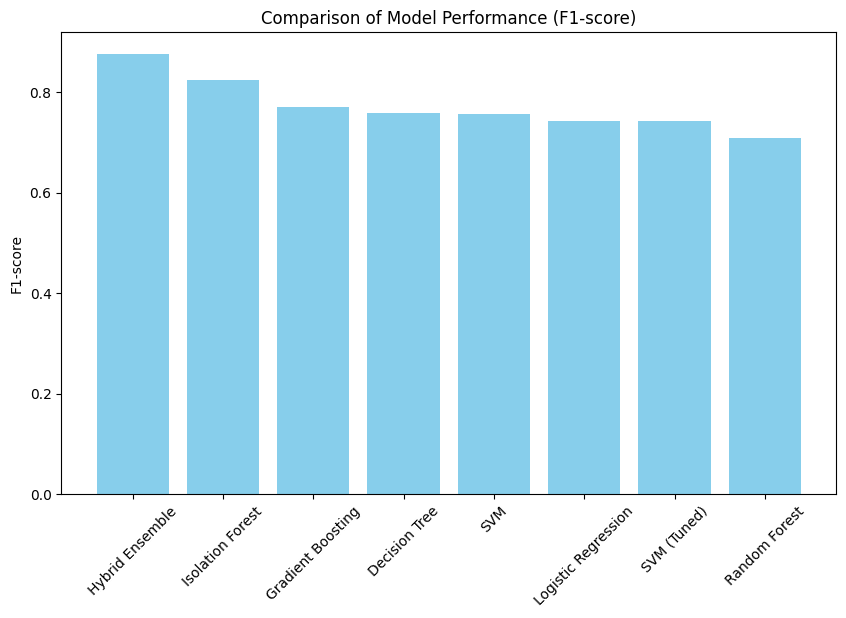

In [67]:


plt.figure(figsize=(10,6))
plt.bar(results_df_sorted.index, results_df_sorted['F1'], color='skyblue')
plt.ylabel('F1-score')
plt.title('Comparison of Model Performance (F1-score)')
plt.xticks(rotation=45)
plt.show()


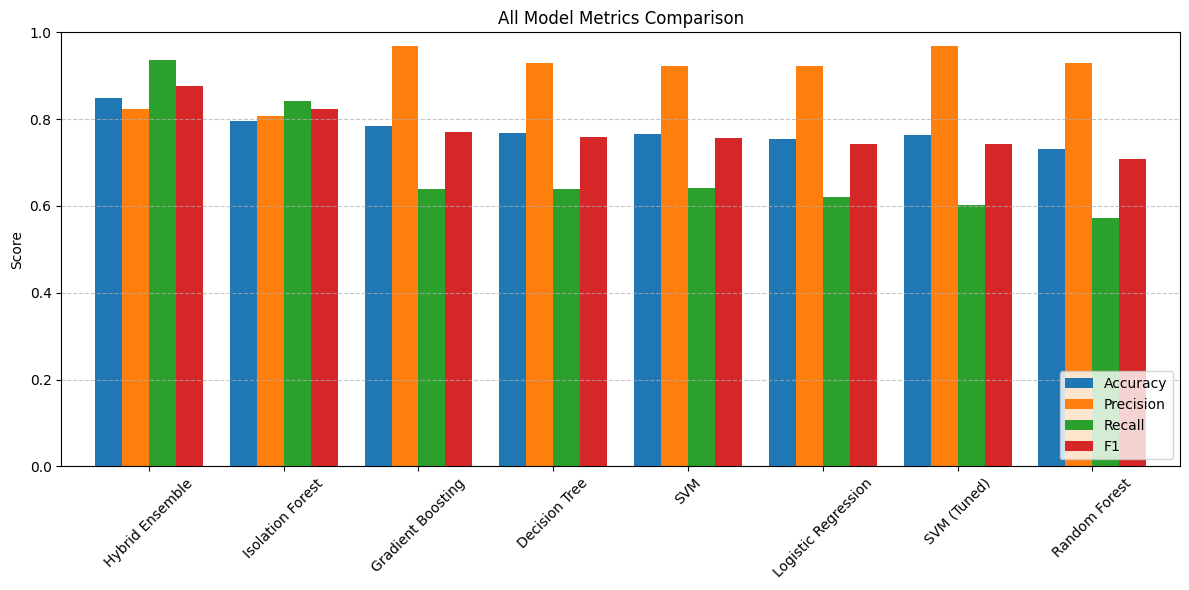

In [68]:
# Plot all metrics as grouped bars
ax = results_df_sorted[['Accuracy', 'Precision', 'Recall', 'F1']].plot(
    kind='bar', figsize=(12,6), width=0.8)

# Add titles and labels
plt.title('All Model Metrics Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)  # all metrics are between 0 and 1
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()